In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

In [2]:
class MazeLoader:
    """Maze file loader and parser."""

    def __init__(self):
        """Initialize loader state."""
        self.lines = []
        self.shape = (0, 0)
        self.wall_num = 0
        self.walls = set()

    def setShape(self):
        """Set maze dimensions."""
        parts = self.lines[0].split()
        if len(parts) != 2:
            raise ValueError(f"Invalid shape line: {self.lines[0]}")
        self.shape = tuple(map(int, parts))

    def setWallNum(self):
        """Set number of walls."""
        parts = self.lines[1].split()
        if len(parts) != 1:
            raise ValueError(f"Invalid wall number line: {self.lines[1]}")
        self.wall_num = int(parts[0])

    def setWalls(self):
        """Parse wall coordinates."""
        wall_lines = self.lines[2:]
        for line in wall_lines:
            parts = tuple(map(int, line.split()))
            if len(parts) != 4:
                raise ValueError(f"Invalid wall definition: {line}")
            r1, c1, r2, c2 = parts
            self.walls.add(((r1, c1), (r2, c2)))

    def load(self, filepath: str):
        """Load maze from file."""
        with open(filepath, "r") as f:
            self.lines = [line.strip() for line in f if line.strip()]
        self.setShape()
        self.setWallNum()
        self.setWalls()
        return self

    def __call__(self, filepath):
        """Call to load maze."""
        return self.load(filepath)

In [3]:
class Environment:
    """Maze simulation environment."""

    def __init__(
        self,
        shape: tuple[int, int],
        walls: set[tuple[tuple[int, int], tuple[int, int]]],
        start: tuple[tuple[int, int], tuple[int, int]],
        goal: tuple[tuple[int, int], tuple[int, int]],
    ):
        """Initialize environment."""
        self.shape = shape
        self.walls = {self.normalizeEdge(w) for w in walls}
        self.start = start
        self.goal = goal
        self.current_pos = self.start
        self.validateStartAndGoal()

    def normalizeEdge(
        self, edge: tuple[tuple[int, int], tuple[int, int]]
    ) -> tuple[tuple[int, int], tuple[int, int]]:
        """Normalize edge."""
        return tuple(sorted(edge))

    def isCellValid(self, cell: tuple[tuple[int, int], tuple[int, int]]) -> bool:
        """Check cell validity."""
        (r1, c1), (r2, c2) = cell
        rows, cols = self.shape
        return (0 <= r1 < r2 <= rows) and (0 <= c1 < c2 <= cols)

    def validateStartAndGoal(self) -> None:
        """Validate start and goal cells."""
        if not (self.isCellValid(self.start) and self.isCellValid(self.goal)):
            raise ValueError("Invalid start and/or goal cell.")

    def getNextPos(self, action) -> None:
        """Compute next position."""
        (r1, c1), (r2, c2) = self.current_pos
        if action == "up":
            return ((r1 - 1, c1), (r2 - 1, c2))
        elif action == "down":
            return ((r1 + 1, c1), (r2 + 1, c2))
        elif action == "left":
            return ((r1, c1 - 1), (r2, c2 - 1))
        elif action == "right":
            return ((r1, c1 + 1), (r2, c2 + 1))
        else:
            raise ValueError(f"Invalid action: {action}")

    def isMoveBlocked(self, next_pos: tuple[tuple[int, int], tuple[int, int]]) -> bool:
        """Check if move is blocked."""
        (r1, c1) = self.current_pos[0]
        (r2, c2) = next_pos[0]

        if r2 == r1 + 1:
            edge = ((r1 + 1, c1), (r1 + 1, c1 + 1))
        elif r2 == r1 - 1:
            edge = ((r1, c1), (r1, c1 + 1))
        elif c2 == c1 + 1:
            edge = ((r1, c1 + 1), (r1 + 1, c1 + 1))
        elif c2 == c1 - 1:
            edge = ((r1, c1), (r1 + 1, c1))
        else:
            return True

        return self.normalizeEdge(edge) in self.walls

    def setNextPos(self, next_pos: tuple[tuple[int, int], tuple[int, int]]) -> None:
        """Update position."""
        if not self.isMoveBlocked(next_pos) and self.isCellValid(next_pos):
            self.current_pos = next_pos

    def getReward(self) -> tuple[tuple[tuple[int, int], tuple[int, int]], float, bool]:
        """Return state, reward, done."""
        done = self.current_pos == self.goal
        reward = 1.0 if done else -0.01
        return self.current_pos, reward, done

    def step(
        self, action: str
    ) -> tuple[tuple[tuple[int, int], tuple[int, int]], float, bool]:
        """Perform action."""
        next_pos = self.getNextPos(action)
        self.setNextPos(next_pos)
        return self.getReward()

    def reset(self) -> tuple[tuple[int, int], tuple[int, int]]:
        """Reset environment."""
        self.current_pos = self.start
        return self.current_pos

    def generateMazeCoords(self) -> np.ndarray:
        """Generate maze coordinates."""
        rows = np.arange(self.shape[0] + 1)
        cols = np.arange(self.shape[1])
        r, c = np.meshgrid(rows, cols, indexing="ij")
        start_coords = np.stack([r, c], axis=-1)
        end_coords = np.stack([r, c + 1], axis=-1)
        return np.stack([start_coords, end_coords], axis=-2)

In [4]:
class EpisodeRenderer:
    """Maze visualization."""

    def __init__(self, env):
        """Init with environment."""
        self.env = env

    def setup_axes(self, ax):
        """Configure axes."""
        rows, cols = self.env.shape
        ax.set_xlim(0, cols)
        ax.set_ylim(rows, 0)
        ax.set_aspect("equal")
        ax.set_xticks(range(cols + 1))
        ax.set_yticks(range(rows + 1))
        ax.grid(False)

    def draw_grid(self, ax):
        """Draw grid lines."""
        rows, cols = self.env.shape
        for row in range(rows):
            ax.plot([0, cols], [row, row], color="lightgray", linewidth=2)
        for col in range(cols + 1):
            ax.plot([col, col], [0, rows], color="lightgray", linewidth=2)

    def draw_walls(self, ax):
        """Draw walls."""
        for (r1, c1), (r2, c2) in self.env.walls:
            ax.plot([c1, c2], [r1, r2], color="black", linewidth=2, clip_on=False)

    def draw_start(self, ax):
        """Draw start cell."""
        (r, c) = self.env.start[0]
        ax.add_patch(patches.Rectangle((c, r), 1, 1, facecolor="#006DA0", alpha=0.5))

    def draw_goal(self, ax):
        """Draw goal cell."""
        (r, c) = self.env.goal[0]
        ax.add_patch(patches.Rectangle((c, r), 1, 1, facecolor="#4CB324", alpha=0.5))

    def plot(self):
        """Draw static maze."""
        fig, ax = plt.subplots(figsize=(self.env.shape[1], self.env.shape[0]))
        self.setup_axes(ax)
        self.draw_grid(ax)
        self.draw_walls(ax)
        self.draw_start(ax)
        self.draw_goal(ax)
        return fig, ax

    def animate_episode(self, positions, ep):
        """Animate episode."""
        fig, ax = self.plot()
        (s_r, s_c), _ = self.env.start
        agent = patches.Circle((s_c + 0.5, s_r + 0.5), 0.2, facecolor="black")
        ax.add_patch(agent)

        def update(frame_idx):
            (r1, c1), _ = positions[frame_idx]
            agent.center = (c1 + 0.5, r1 + 0.5)
            return (agent,)

        ani = animation.FuncAnimation(
            fig=fig,
            func=update,
            frames=len(positions),
            interval=200,
            
        )
        ani.save(f"./episodes/ep_{ep}.gif", writer="pillow", fps=5)
        plt.show()

In [5]:
class Agent:
    def __init__(
        self,
        env: Environment,
        alpha: float = 0.5,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        """Q-learning agent."""
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = ["up", "down", "left", "right"]
        self.Q = self.initializeQ()

    def initializeQ(self) -> np.ndarray:
        """Init Q-table."""
        rows, cols = self.env.shape
        return np.zeros((rows, cols, len(self.actions)))

    def chooseAction(self, state) -> str:
        """Select action."""
        r, c = state
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.Q[r, c, :])]

    def updateQ(self, state, action, reward, next_state) -> None:
        """Update Q-value."""
        r, c = state
        a = self.actions.index(action)
        nr, nc = next_state
        max_next = np.max(self.Q[nr, nc, :])
        self.Q[r, c, a] += self.alpha * (
            reward + self.gamma * max_next - self.Q[r, c, a]
        )

    def printQ(self) -> None:
        """Print Q-table."""
        print(f"{np.array2string(self.Q, precision=2, suppress_small=True)}\n")

In [6]:
class Trainer:
    """Agent trainer."""

    def __init__(self, env, agent, episodes: int = 300):
        """Init trainer."""
        self.env = env
        self.agent = agent
        self.renderer = EpisodeRenderer(env)
        self.episodes = episodes
        self.rewards_per_episode = []

    def train(self, show_episodes=True, show_every=100) -> None:
        """Run training."""
        for ep in range(1, self.episodes + 1):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            positions = []

            while not done:
                state, reward, done = self.stepEpisode(state)
                positions.append(self.env.current_pos)
                total_reward += reward

            if show_episodes and (ep % show_every == 0):
                print(f"Moves at episode {ep}:")
                self.renderer.animate_episode(positions, ep)
                self.showQ(ep)

            self.rewards_per_episode.append(total_reward)

    def stepEpisode(
        self, state: tuple[int, int]
    ) -> tuple[tuple[int, int], float, bool]:
        """Step one action."""
        action = self.agent.chooseAction(state)
        next_pos, reward, done = self.env.step(action)
        next_state = next_pos[0]
        self.agent.updateQ(state, action, reward, next_state)
        return next_state, reward, done

    def showQ(self, ep: int) -> None:
        """Print Q-table."""
        print(f"Q-table at episode {ep}:")
        self.agent.printQ()

    def printFinalStats(self) -> None:
        """Print stats."""
        total_episodes = len(self.rewards_per_episode)
        total_reward = np.sum(self.rewards_per_episode)
        mean_reward = np.mean(self.rewards_per_episode)
        best_reward = np.max(self.rewards_per_episode)
        worst_reward = np.min(self.rewards_per_episode)

        print("===== Training Summary =====")
        print(f"Total Episodes: {total_episodes}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Average Reward per Episode: {mean_reward:.2f}")
        print(f"Best Episode Reward: {best_reward:.2f}")
        print(f"Worst Episode Reward: {worst_reward:.2f}")
        print("============================")

    def plotRewardsPerEpisode(self) -> None:
        """Plot rewards."""
        plt.plot(self.rewards_per_episode)
        plt.title("Rewards per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.grid(True)
        plt.show()

    def __call__(self, *args, **kwargs):
        """Call train."""
        self.train(*args, **kwargs)

Moves at episode 100:


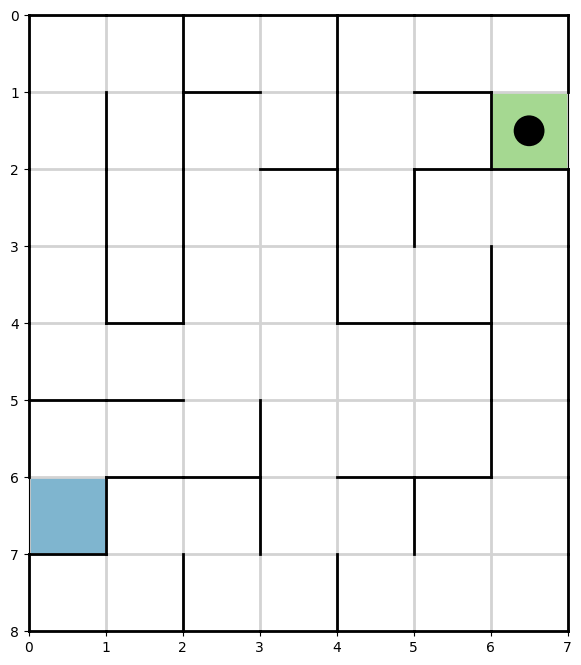

Q-table at episode 100:
[[[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.61  0.25  0.67  0.79]
  [ 0.74  0.59  0.33  0.89]
  [ 0.67  1.    0.74  0.76]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.48  0.54  0.12]
  [-0.02 -0.02  0.46 -0.02]
  [ 0.    0.    0.    0.  ]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.62  0.36  0.51  0.21]
  [ 0.27  0.43  0.33  0.28]
  [ 0.3   0.28  0.37  0.14]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.02 -0.08 -0.08]
  [ 0.55 -0.03  0.45  0.37]
  [ 0.32  0.31  0.48  0.4 ]
  [ 0.33 -0.05  0.12  0.12]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.01 -0.08  0.03]
  [-0.08  0.05 -0.01 -0.07]
  [-0.08 -0.02 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.28  0.08  

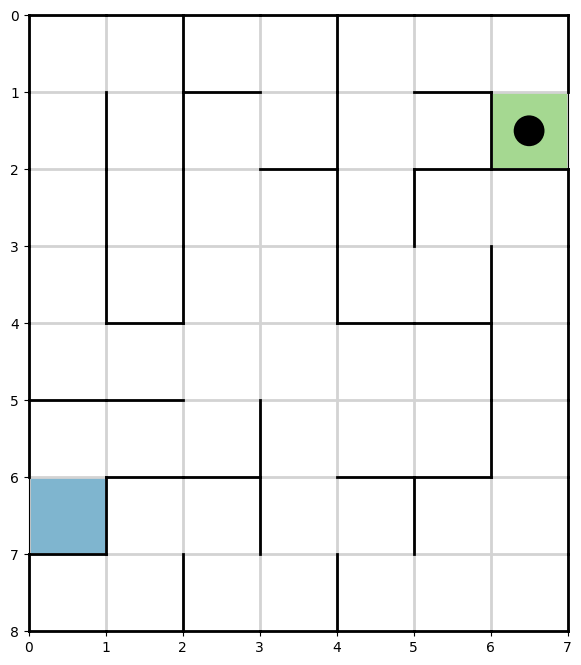

Q-table at episode 200:
[[[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.66  0.58  0.67  0.79]
  [ 0.74  0.74  0.61  0.89]
  [ 0.88  1.    0.78  0.76]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.53  0.61  0.37]
  [-0.02 -0.02  0.58 -0.02]
  [ 0.    0.    0.    0.  ]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.62  0.48  0.55  0.53]
  [ 0.36  0.43  0.37  0.33]
  [ 0.33  0.28  0.37  0.28]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08  0.02]
  [-0.08  0.03 -0.08 -0.01]
  [ 0.55  0.36  0.48  0.41]
  [ 0.37  0.4   0.48  0.41]
  [ 0.33  0.23  0.27  0.28]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.03]
  [-0.01  0.01 -0.08  0.03]
  [-0.01  0.05  0.02 -0.01]
  [-0.08  0.03 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.28  0.21  

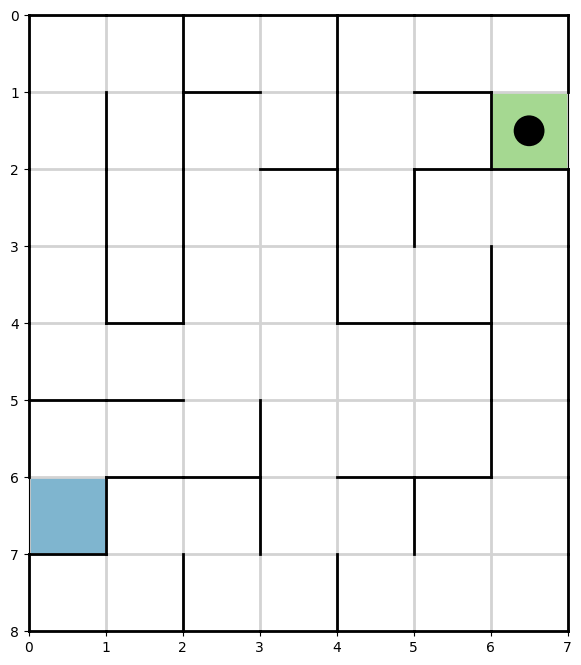

Q-table at episode 300:
[[[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.62  0.69  0.79]
  [ 0.79  0.78  0.66  0.89]
  [ 0.89  1.    0.79  0.89]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.55  0.62  0.49]
  [-0.02 -0.02  0.61  0.25]
  [ 0.    0.    0.    0.  ]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.62  0.48  0.55  0.54]
  [ 0.37  0.43  0.37  0.33]
  [ 0.33  0.28  0.37  0.31]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08  0.02]
  [-0.08  0.03 -0.08 -0.01]
  [ 0.55  0.48  0.48  0.43]
  [ 0.37  0.43  0.48  0.42]
  [ 0.33  0.24  0.28  0.28]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.03]
  [-0.    0.01 -0.08  0.03]
  [ 0.02  0.05  0.02  0.01]
  [-0.08  0.03 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.28  0.21  

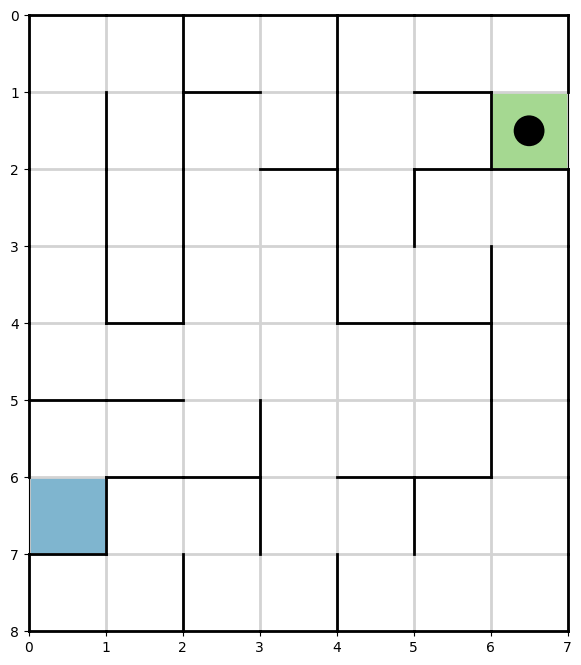

Q-table at episode 400:
[[[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.62  0.7   0.79]
  [ 0.79  0.79  0.7   0.89]
  [ 0.89  1.    0.79  0.89]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.55  0.62  0.53]
  [-0.02 -0.02  0.62  0.25]
  [ 0.    0.    0.    0.  ]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.03 -0.08 -0.08]
  [ 0.62  0.48  0.55  0.54]
  [ 0.37  0.43  0.37  0.33]
  [ 0.33  0.28  0.37  0.32]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08  0.02]
  [-0.08  0.03 -0.08 -0.01]
  [ 0.55  0.48  0.48  0.43]
  [ 0.37  0.43  0.48  0.43]
  [ 0.33  0.24  0.28  0.28]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.  ]
  [ 0.01  0.01 -0.06  0.03]
  [ 0.02  0.05  0.02  0.02]
  [-0.08  0.03 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.28  0.21  

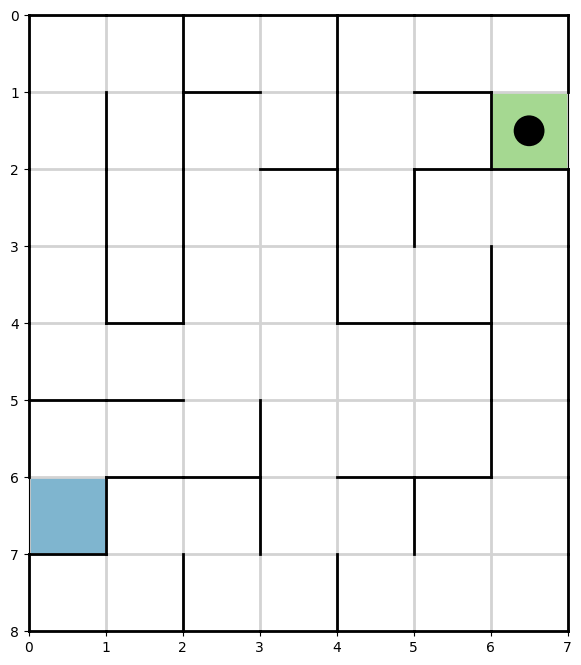

Q-table at episode 500:
[[[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.62  0.7   0.79]
  [ 0.79  0.79  0.7   0.89]
  [ 0.89  1.    0.79  0.89]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.7   0.55  0.62  0.54]
  [-0.02 -0.02  0.62  0.25]
  [ 0.    0.    0.    0.  ]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.03 -0.08 -0.08]
  [ 0.62  0.48  0.55  0.55]
  [ 0.37  0.43  0.37  0.33]
  [ 0.33  0.28  0.37  0.33]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08  0.02]
  [-0.08  0.03 -0.08 -0.01]
  [ 0.55  0.48  0.48  0.43]
  [ 0.37  0.43  0.48  0.43]
  [ 0.33  0.24  0.28  0.28]]

 [[-0.08 -0.08 -0.08 -0.08]
  [-0.08 -0.08 -0.08  0.01]
  [ 0.01  0.01 -0.02  0.03]
  [ 0.02  0.05  0.02  0.02]
  [-0.08  0.03 -0.08 -0.08]
  [-0.08 -0.08 -0.08 -0.08]
  [ 0.28  0.21  

In [7]:
loader = MazeLoader()("./mazes/maze_2.txt")
start = ((6, 0), (7, 1))
goal = ((1, 6), (2, 7))
env = Environment(shape=loader.shape, walls=loader.walls, start=start, goal=goal)
agent = Agent(env=env, alpha=0.5, gamma=0.9, epsilon=0.1)
trainer = Trainer(env=env, agent=agent, episodes=500)
trainer()

===== Training Summary =====
Total Episodes: 500
Total Reward: 309.59
Average Reward per Episode: 0.62
Best Episode Reward: 0.76
Worst Episode Reward: -4.50


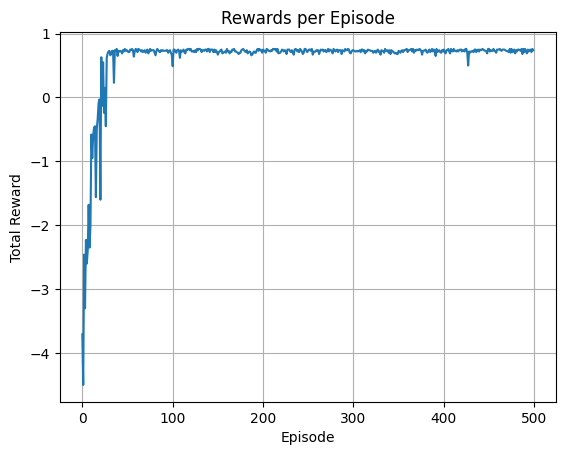

In [8]:
trainer.printFinalStats()
trainer.plotRewardsPerEpisode()